# 종목별 데이터 셋 생성하기

### 재무제표 불러오기 (10년)

In [1]:
# 개발 가이드 https://opendart.fss.or.kr/guide/main.do?apiGrpCd=DS001
# 키 ef1bb5ab681bc62b16ac450a6fc77cad65cd61a6
# 개발 가이드 더 상세 https://dart-fss.readthedocs.io/en/latest/dart_fs.html

import dart_fss as dart

# Open DART API KEY 설정
api_key='	4563988d3519220f5a4ca932fedbf8806bb02cdf'
dart.set_api_key(api_key=api_key)

# DART 에 공시된 회사 리스트 불러오기
corp_list = dart.get_corp_list()

# 삼성전자 검색
################이부분 수정
samsung = corp_list.find_by_corp_name('삼성전자', exactly=True)[0]

# 2022년부터 연간 연결재무제표 불러오기
fs = samsung.extract_fs(bgn_de='20130101')

# 재무제표 검색 결과를 엑셀파일로 저장 ( 기본저장위치: 실행폴더/fsdata )
# fs.save()

bs_df = fs['bs']
cis_df = fs['cis']
is_df = fs['is']
cf_df = fs['cf']

#droplevel로 2중 column 중 하나 제거 (level = 1 은 두번째 column 제거를 의미)
imsi_df = bs_df.iloc[[43,51,52,47],:].droplevel(axis=1,level=1)

#bs_df의 column 명 바꾸고 필요한 column만 추출하기 - 자본금, 자본총계, 부채와자본금

# 전체 열 이름 입력하기

# 선택하여 열 이름 변경하기
imsi2_df=imsi_df.rename(columns={'[D210000] Statement of financial position, current/non-current - Consolidated financial statements (Unit: KRW)':'이름'})
# bs
final_bs_df = imsi2_df.iloc[:,[1,8,9,10,11,12,13,14,15,16,17]]

#is_df의 column 명 바꾸고 필요한 column만 추출하기 - 수익(매출액)과 영업이익 추출

imsi_df = is_df.iloc[[0,4,16],:].droplevel(axis=1,level=1)
imsi2_df=imsi_df.rename(columns={'[D310000] Income statement, by function of expense - Consolidated financial statements (Unit: KRW)':'이름'})
final_is_df = imsi2_df.iloc[:,[1,6,7,8,9,10,11,12,13,14,15]]
#cis_df의 column 명 바꾸고 필요한 column만 추출하기 - 당기순이익(손실)

imsi_df = cis_df.iloc[[0],:].droplevel(axis=1,level=1)
imsi2_df=imsi_df.rename(columns={'[D410000] Statement of comprehensive income - Consolidated financial statements (Unit: KRW)':'이름'})
final_cis_df = imsi2_df.iloc[:,[1,7,8,9,10,11,12,13,14,15,16]]
#is, cis의 데이터 column bs 기준으로 단순 날짜로 통일
index = ['이름','20221231','20211231','20201231','20191231','20181231','20171231','20161231','20151231','20141231','20131231']
final_cis_df.columns = index
final_is_df.columns = index
#bs,is,cis 한 final_df로 데이터 합치기

import pandas as pd
b_df = pd.concat([final_bs_df,final_is_df])
c_df = pd.concat([b_df,final_cis_df])
final_df = c_df

#final_df의 인덱스를 이름으로 수정

final_df=final_df.reset_index()
final_df=final_df.iloc[:,1:]
final_df

final_df=final_df.set_index('이름')

#수집한 데이터로 부채비율, ROE, 영업이익률 계산하기
#부채비율 = 부채 총계/ 자본 총계 = (부채와자본총계-자본총계) / 자본총계
#roe = 당기순이익/자기자본(자본금) * 100 = 당기순이익/(자본금+이익잉여금(결손금)) * 100
#영업이익률 = 영업이익/수익(매출액) * 100
#eps = 기본주당수익

roe_df = final_df.loc['당기순이익(손실)']/(final_df.loc['자본금']+final_df.loc['이익잉여금(결손금)']) * 100
roe_df.name='ROE'
yu_df = final_df.loc['영업이익']/final_df.loc['수익(매출액)'] *100
yu_df.name = '영업이익률'
# 부채비율 = 부채 총계/ 자본 총계 = (부채와자본총계-자본총계) / 자본총계
# 값 정확
bc_df = (final_df.loc['부채와자본총계']-final_df.loc['자본총계'])/final_df.loc['자본총계'] * 100
bc_df.name = '부채비율'
# eps = 기본주당이익
eps_df = final_df.loc['기본주당이익(손실)']
eps_df.name = 'EPS'
# 순이익률 = 당기순이익(손실)/수익(매출액)
ros_df = final_df.loc['당기순이익(손실)']/final_df.loc['수익(매출액)'] * 100
ros_df.name = "순이익률"
# BPS = 자본총계 * 기본주당이익(손실) / 당기순이익(손실)
bps_df = final_df.loc['자본총계'] *final_df.loc['기본주당이익(손실)']/final_df.loc['당기순이익(손실)']
bps_df.name = "BPS"
real_final_df=pd.concat([roe_df,yu_df,bc_df,eps_df,ros_df, bps_df],axis=1)
real_final_df

Output()

Output()

Output()

Annual reports:   0%|          | 0/11 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "C:\Users\leeji\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "C:\Users\leeji\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\leeji\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\leeji\anaconda3\lib\http\client.py", line 1347, in getresponse
    response.begin()
  File "C:\Users\leeji\anaconda3\lib\http\client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "C:\Users\leeji\anaconda3\lib\http\client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\leeji\anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\leeji\anaco

urllib3.exceptions.ProtocolError: ('Connection aborted.', ConnectionResetError(10054, '현재 연결은 원격 호스트에 의해 강제로 끊겼습니다', None, 10054, None))

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\leeji\anaconda3\lib\site-packages\dart_fss\fs\extract.py", line 1435, in extract
    nstatements = analyze_report(report=report,
  File "C:\Users\leeji\anaconda3\lib\site-packages\dart_fss\fs\extract.py", line 1257, in analyze_report
    xbrl = report.xbrl
  File "C:\Users\leeji\anaconda3\lib\site-packages\dart_fss\filings\reports.py", line 377, in xbrl
    self.load_xbrl()
  File "C:\Users\leeji\anaconda3\lib\site-packages\dart_fss\filings\reports.py", line 386, in load_xbrl
    file_path = download_xbrl(path=path, rcept_no=self.rcept_no)
  File "C:\Users\leeji\anaconda3\lib\site-packages\dart_fss\api\finance\xbrl.py", line 38, in download_xbrl
    resp = request.download(url=url, path=temp, payload=payload)
  File "C:\Users\leeji

,ROE,영업이익률,부채비율,EPS,순이익률,BPS
20221231,16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"
20211231,13.575704477210863,18.466727389754137,39.921697128885214,"5,777.0",14.272805811176367,"44,137.29520144735"
20201231,9.709985329952882,15.199668009797076,37.06774322305691,"3,841.0",11.151626995061479,"40,136.438669255396"
20191231,8.509014515116947,12.052258168231571,34.11592071362362,"3,166.0",9.435235189052944,"38,285.32045651878"
20181231,18.204228082615483,24.1565111315451,36.97392223551587,"6,461.0",18.191163635818416,"36,097.382760688575"
20171231,19.467028446304194,22.391716083542743,40.68258709154568,"5,997.0",17.608966206944405,"30,490.73903982215"
20161231,11.715456841348804,14.485135726540793,35.867642586235675,"3,159.0",11.257967229817869,"26,822.483216516066"
20151231,10.245762704940047,13.163709763083006,35.25063371983455,"126,305.0",9.499034758838624,"1,186,567.5658339728"
20141231,13.726898790836797,12.135957526781219,37.08456301521913,"153,105.0",11.345140041932925,"1,100,057.6302944496"
20131231,20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"


In [3]:
real_final_df.index.name='Date'
real_final_df


,ROE,영업이익률,부채비율,EPS,순이익률,BPS
Date,,,,,,
20221231,16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"
20211231,13.575704477210863,18.466727389754137,39.921697128885214,"5,777.0",14.272805811176367,"44,137.29520144735"
20201231,9.709985329952882,15.199668009797076,37.06774322305691,"3,841.0",11.151626995061479,"40,136.438669255396"
20191231,8.509014515116947,12.052258168231571,34.11592071362362,"3,166.0",9.435235189052944,"38,285.32045651878"
20181231,18.204228082615483,24.1565111315451,36.97392223551587,"6,461.0",18.191163635818416,"36,097.382760688575"
20171231,19.467028446304194,22.391716083542743,40.68258709154568,"5,997.0",17.608966206944405,"30,490.73903982215"
20161231,11.715456841348804,14.485135726540793,35.867642586235675,"3,159.0",11.257967229817869,"26,822.483216516066"
20151231,10.245762704940047,13.163709763083006,35.25063371983455,"126,305.0",9.499034758838624,"1,186,567.5658339728"
20141231,13.726898790836797,12.135957526781219,37.08456301521913,"153,105.0",11.345140041932925,"1,100,057.6302944496"


In [13]:
real_final_df.index= real_final_df.index.astype('str')
real_final_df.index = pd.to_datetime(real_final_df.index)

In [16]:
real_final_df.reset_index(inplace=True)

In [17]:
real_final_df

,Date,ROE,영업이익률,부채비율,EPS,순이익률,BPS
0,2022-12-31,16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"
1,2021-12-31,13.575704477210863,18.466727389754137,39.921697128885214,"5,777.0",14.272805811176367,"44,137.29520144735"
2,2020-12-31,9.709985329952882,15.199668009797076,37.06774322305691,"3,841.0",11.151626995061479,"40,136.438669255396"
3,2019-12-31,8.509014515116947,12.052258168231571,34.11592071362362,"3,166.0",9.435235189052944,"38,285.32045651878"
4,2018-12-31,18.204228082615483,24.1565111315451,36.97392223551587,"6,461.0",18.191163635818416,"36,097.382760688575"
5,2017-12-31,19.467028446304194,22.391716083542743,40.68258709154568,"5,997.0",17.608966206944405,"30,490.73903982215"
6,2016-12-31,11.715456841348804,14.485135726540793,35.867642586235675,"3,159.0",11.257967229817869,"26,822.483216516066"
7,2015-12-31,10.245762704940047,13.163709763083006,35.25063371983455,"126,305.0",9.499034758838624,"1,186,567.5658339728"
8,2014-12-31,13.726898790836797,12.135957526781219,37.08456301521913,"153,105.0",11.345140041932925,"1,100,057.6302944496"
9,2013-12-31,20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"


### 환율 , 금리, 종가

In [6]:
import yfinance as yf
import requests
import pandas as pd

start_date = '2013-01-01'
end_date = '2023-01-01'
data = yf.download(['USDKRW=X'],start=start_date, end=end_date)
data=data[['Close']]
data =data.rename(columns={'Close':'환율'})

[*********************100%***********************]  1 of 1 completed


In [7]:
apikey='EPJ2CONXWQOE8KWK59GV'

#장기데이터수집
url = 'https://ecos.bok.or.kr/api/StatisticSearch/' + apikey \
        + '/json/kr/1/100/722Y001/D/20060101/20230315/0101000'
response = requests.get(url)
result = response.json()
list_total_count=(int)(result['StatisticSearch']['list_total_count'])
list_count=(int)(list_total_count/100) + 1


rows=[]
for i in range(0,list_count):
    start = str(i * 100 + 1)
    end = str((i + 1) * 100)
    
    url = 'https://ecos.bok.or.kr/api/StatisticSearch/' + apikey + '/json/kr/' \
            + start + '/' + end + '/722Y001/D/20130101/20230101/0101000'
    response = requests.get(url)
    result = response.json()
    rows = rows + result['StatisticSearch']['row']
    
df=pd.DataFrame(rows)
df1=df[['ITEM_NAME1','TIME','DATA_VALUE']]
df1['date']=pd.to_datetime((df1['TIME'].str[:4] + '-' + df1['TIME'].str[4:6] + '-' + df1['TIME'].str[6:8]))
df1=df1.astype({'DATA_VALUE':'float'})
df1=df1.drop_duplicates()
df1=df1[['DATA_VALUE', 'date']]
df1 =df1.rename(columns={'DATA_VALUE':'금리'})
df1 =df1.rename(columns={'date':'Date'})


C:\Users\leeji\AppData\Local\Temp\ipykernel_22916\2439554960.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date']=pd.to_datetime((df1['TIME'].str[:4] + '-' + df1['TIME'].str[4:6] + '-' + df1['TIME'].str[6:8]))


In [8]:
import FinanceDataReader as fdr
################이부분 수정
df2 = fdr.DataReader('005930',"2013-01-01", "2023-01-01")
df2=df2[['Close']]

In [9]:
df=pd.merge(data, df1, on = 'Date', how = 'outer')
df=pd.merge(df, df2, on = 'Date', how = 'outer')
df

,Date,환율,금리,Close
0,2013-01-01,"1,062.5",2.75,NaN
1,2013-01-02,"1,062.5",2.75,"31,520.0"
2,2013-01-03,"1,062.5999755859375",2.75,"30,860.0"
3,2013-01-04,"1,061.9000244140625",2.75,"30,500.0"
4,2013-01-07,"1,033.0999755859375",2.75,"30,400.0"
...,...,...,...,...
3647,2022-12-18,NaN,3.25,NaN
3648,2022-12-24,NaN,3.25,NaN
3649,2022-12-25,NaN,3.25,NaN
3650,2022-12-31,NaN,3.25,NaN


In [10]:
df=df.fillna(method='ffill')
df

,Date,환율,금리,Close
0,2013-01-01,"1,062.5",2.75,NaN
1,2013-01-02,"1,062.5",2.75,"31,520.0"
2,2013-01-03,"1,062.5999755859375",2.75,"30,860.0"
3,2013-01-04,"1,061.9000244140625",2.75,"30,500.0"
4,2013-01-07,"1,033.0999755859375",2.75,"30,400.0"
...,...,...,...,...
3647,2022-12-18,"1,260.260009765625",3.25,"43,500.0"
3648,2022-12-24,"1,260.260009765625",3.25,"43,500.0"
3649,2022-12-25,"1,260.260009765625",3.25,"43,500.0"
3650,2022-12-31,"1,260.260009765625",3.25,"43,500.0"


In [18]:
df=pd.merge(df, real_final_df,on = 'Date', how = 'outer')
df=df.fillna(method='bfill')
df

,Date,환율,금리,Close,ROE,영업이익률,부채비율,EPS,순이익률,BPS
0,2013-01-01,"1,062.5",2.75,"31,520.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
1,2013-01-02,"1,062.5",2.75,"31,520.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
2,2013-01-03,"1,062.5999755859375",2.75,"30,860.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
3,2013-01-04,"1,061.9000244140625",2.75,"30,500.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
4,2013-01-07,"1,033.0999755859375",2.75,"30,400.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-18,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"
3648,2022-12-24,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"
3649,2022-12-25,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"
3650,2022-12-31,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"


In [19]:
df=df.fillna(method='ffill')
df

,Date,환율,금리,Close,ROE,영업이익률,부채비율,EPS,순이익률,BPS
0,2013-01-01,"1,062.5",2.75,"31,520.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
1,2013-01-02,"1,062.5",2.75,"31,520.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
2,2013-01-03,"1,062.5999755859375",2.75,"30,860.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
3,2013-01-04,"1,061.9000244140625",2.75,"30,500.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
4,2013-01-07,"1,033.0999755859375",2.75,"30,400.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326"
...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-18,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"
3648,2022-12-24,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"
3649,2022-12-25,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"
3650,2022-12-31,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712"


In [20]:
## 재무제표 남은 변수 생성
#수집한 데이터로 부채비율, ROE, 영업이익률 계산하기
#부채비율 = 부채 총계/ 자본 총계 = (부채와자본총계-자본총계) / 자본총계
#roe = 당기순이익/자기자본(자본금) * 100 = 당기순이익/(자본금+이익잉여금(결손금)) * 100
#영업이익률 = 영업이익/수익(매출액) * 100
#eps = 기본주당수익

In [23]:
df =df.rename(columns={'Close':'종가'})
per_df = df['종가'] / df['EPS']
per_df.name = "PER"
pbr_df = df['종가'] / df['BPS']
pbr_df.name = "PBR"
df = pd.concat([df, per_df, pbr_df], axis=1)
df

,Date,환율,금리,종가,ROE,영업이익률,부채비율,EPS,순이익률,BPS,PER,PBR
0,2013-01-01,"1,062.5",2.75,"31,520.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326",0.1593198578656598,0.03236477939234303
1,2013-01-02,"1,062.5",2.75,"31,520.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326",0.1593198578656598,0.03236477939234303
2,2013-01-03,"1,062.5999755859375",2.75,"30,860.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326",0.15598384561339662,0.031687090483747016
3,2013-01-04,"1,061.9000244140625",2.75,"30,500.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326",0.1541642025667076,0.03131744198814919
4,2013-01-07,"1,033.0999755859375",2.75,"30,400.0",20.384758046867795,16.084911458923166,42.70144766548584,"197,841.0",13.325641088439447,"973,898.1878386326",0.15365874616484956,0.03121476185048313
...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2022-12-18,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712",5.399031897728683,0.847014721295216
3648,2022-12-24,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712",5.399031897728683,0.847014721295216
3649,2022-12-25,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712",5.399031897728683,0.847014721295216
3650,2022-12-31,"1,260.260009765625",3.25,"43,500.0",16.424693952234133,14.352127456263968,26.405921794911997,"8,057.0",18.41439518387503,"51,356.84056763712",5.399031897728683,0.847014721295216


In [24]:
df.columns

Index(['Date', '환율', '금리', '종가', 'ROE', '영업이익률', '부채비율', 'EPS', '순이익률', 'BPS',
       'PER', 'PBR'],
      dtype='object')

In [25]:
features_considered = ['환율', '금리', '종가', 'ROE', '영업이익률', '부채비율', 'EPS', '순이익률', 'BPS',
       'PER', 'PBR']
features = df[features_considered]
features.index = df['Date']
print(features.head())

                            환율   금리       종가                ROE  \
Date                                                              
2013-01-01             1,062.5 2.75 31,520.0 20.384758046867795   
2013-01-02             1,062.5 2.75 31,520.0 20.384758046867795   
2013-01-03 1,062.5999755859375 2.75 30,860.0 20.384758046867795   
2013-01-04 1,061.9000244140625 2.75 30,500.0 20.384758046867795   
2013-01-07 1,033.0999755859375 2.75 30,400.0 20.384758046867795   

                        영업이익률              부채비율       EPS               순이익률  \
Date                                                                           
2013-01-01 16.084911458923166 42.70144766548584 197,841.0 13.325641088439447   
2013-01-02 16.084911458923166 42.70144766548584 197,841.0 13.325641088439447   
2013-01-03 16.084911458923166 42.70144766548584 197,841.0 13.325641088439447   
2013-01-04 16.084911458923166 42.70144766548584 197,841.0 13.325641088439447   
2013-01-07 16.084911458923166 42.70144766548584 19

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3652 entries, 0 to 3651
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3652 non-null   datetime64[ns]
 1   환율      3652 non-null   float64       
 2   금리      3652 non-null   float64       
 3   종가      3652 non-null   float64       
 4   ROE     3652 non-null   float64       
 5   영업이익률   3652 non-null   float64       
 6   부채비율    3652 non-null   float64       
 7   EPS     3652 non-null   float64       
 8   순이익률    3652 non-null   float64       
 9   BPS     3652 non-null   float64       
 10  PER     3652 non-null   float64       
 11  PBR     3652 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 370.9 KB


<Figure size 15000x8000 with 0 Axes>

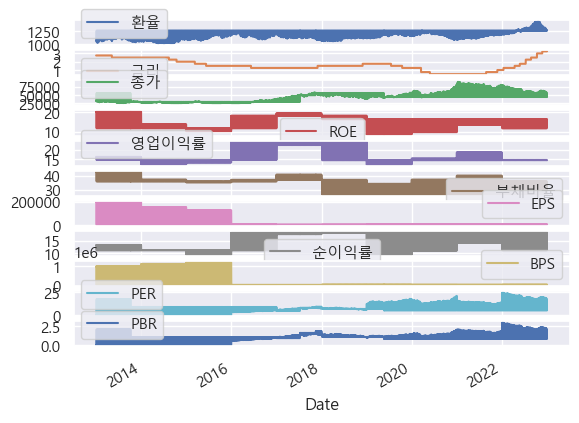

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os 
if os.name =='nt':
    font_family ="Malgun Gothic"
else:
    font_family ="AppleGothic"
    
sns.set(font=font_family, rc={"axes.unicode_minus": False})
plt.figure(figsize=(150,80))
features.plot(subplots=True)
plt.show()